In [1]:
import os
import json

import torch

from stnn import SaptioTemporalNN
from utils import rmse
from datasets import dataset_factory

import matplotlib.pyplot as plt

%matplotlib inline

## Data

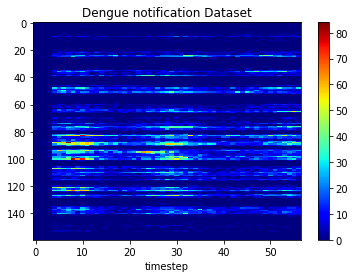

In [2]:
datadir = 'data'
dataset = 'dengue'
_, (train_data, test_data), _ = dataset_factory(datadir, dataset)

plt.figure('Dengue notification Dataset')
plt.imshow(torch.cat((train_data, test_data)).squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Dengue notification Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Training

In [3]:
run train_stnn.py --dataset dengue --outputdir output --manualSeed 2021 --xp stnn

100%|██████████| 10000/10000 [11:43<00:00,  7.33it/s, loss=0.0158, rmse_test=2.72]


<Figure size 432x288 with 0 Axes>

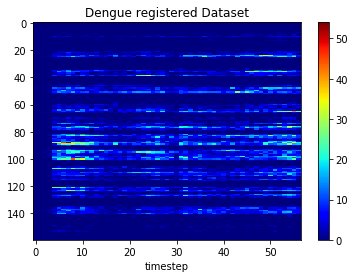

In [4]:
datadir = 'data'
dataset = 'registeredcases'
_, (train_data, test_data), _ = dataset_factory(datadir, dataset)

plt.figure('Dengue registered Dataset')
plt.imshow(torch.cat((train_data, test_data)).squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Dengue registered Dataset')
plt.xlabel('timestep')
plt.colorbar()

In [5]:
run train_stnn.py --dataset registeredcases --outputdir output-data --manualSeed 2021 --xp stnn

100%|██████████| 10000/10000 [11:45<00:00,  7.86it/s, loss=0.0101, rmse_test=2.23]


<Figure size 432x288 with 0 Axes>

## Model

In [6]:
outputdir = 'output'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_data, test_data), relations = dataset_factory(datadir, dataset, config['khop'])

    model = SaptioTemporalNN(relations, 160, 53, 1, config['nz'], config['mode'], config['nhid'],
                             config['nlayers'], config['dropout_f'], config['dropout_d'],
                             config['activation'], config['periode'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [8]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction, _ = model.generate(4)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
    print('RMSE {}:\t'.format(exp), mse)

RMSE stnn:	 2.5457582473754883


In [18]:
## Final_Prediction

In [9]:
outputdir = 'output-data'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_data, test_data), relations = dataset_factory(datadir, dataset, config['khop'])

    model = SaptioTemporalNN(relations, 160, 53, 1, config['nz'], config['mode'], config['nhid'],
                             config['nlayers'], config['dropout_f'], config['dropout_d'],
                             config['activation'], config['periode'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

In [10]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction, _ = model.generate(4)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
    print('RMSE {}:\t'.format(exp), mse)

RMSE stnn:	 2.2335872650146484


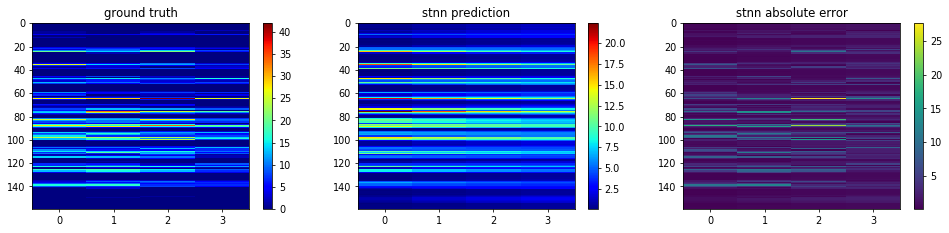

In [11]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))